In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import optuna
import os

from functions import *



# orca 10 Data

Now as the total of data for the atmospheric neutrinos has 14597 entries, we select 14597 entries from the muon dataset as wel. This is to create a more balanced training dataset.


## loading and preselecting data

In [4]:
neutr_paths = os.listdir("datav2")
muon_path = "datav2/"+neutr_paths.pop(-2)
neutr_types = [12,14,16,-12,-14,-16,14,-14]
is_CC = [1,0,1,1,1,1,1,0]
for i, path in enumerate(neutr_paths):
    # print(path)
    # print(neutr_types[i])
    # print(is_CC[i])
    neutr_paths[i] = "datav2/"+path


study_name = "RDF_optuna_study_preselec"  
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name = study_name, direction="maximize", storage= storage_name, load_if_exists= True)
best_params = study.best_params

print(best_params)

df_atm_muon, df_atm_neutr = load_RFD_data(muon_path, neutr_paths, neutr_types, is_CC)
# Combine the dataframes
df = pd.concat([df_atm_muon, df_atm_neutr], join= 'inner', ignore_index=True)
# print(df.value_counts('label'))

print(df.columns)

# Simulation data
reco_columns = [column for column in df.columns if column[:5] == "jmuon"]
y_full = df.drop(columns=reco_columns)
X_full = df[reco_columns]
X_full = X_full.drop(columns=["jmuon_group_id"])
y_full = df.drop(columns=reco_columns)

value_counts_pre = y_full.value_counts('label')

neutrino_count_pre_selection = y_full["label"].sum()

n_neutrs_below_10Gev_pre = y_full[(y_full["label"] == 1) & (X_full["jmuon_E"]<10)].shape[0]
n_neutrs_above_10Gev_pre = y_full[(y_full["label"] == 1) & (X_full["jmuon_E"]>=10)].shape[0]


energy_crit = 20

centre_x = X_full["jmuon_pos_x"].min() + (X_full['jmuon_pos_x'].max() - X_full['jmuon_pos_x'].min())/2
centre_y = X_full["jmuon_pos_y"].min() + (X_full['jmuon_pos_y'].max() - X_full['jmuon_pos_y'].min())/2
approx_r = ((X_full["jmuon_pos_x"].max() - X_full["jmuon_pos_x"].min())/2+(X_full["jmuon_pos_y"].max() - X_full['jmuon_pos_y'].min())/2)/2

radius_crit = best_params["radius_crit"]
likelihood_crit = best_params["likelihood_crit"]
pos_z_crit = best_params["pos_z_crit"]


threshold_likelihood = np.percentile(X_full['jmuon_likelihood'], likelihood_crit)

mask_z_dir = X_full['jmuon_dir_z'] > 0
mask_energy = X_full['jmuon_E'] < energy_crit
mask_radius = np.sqrt((X_full['jmuon_pos_x'] - centre_x)**2 + (X_full['jmuon_pos_y'] - centre_y)**2) < approx_r*radius_crit
mask_pos_z = X_full['jmuon_pos_z'] > pos_z_crit
mask_likelihood = X_full['jmuon_likelihood'] > threshold_likelihood
mask_geometry = mask_pos_z | mask_radius

mask = mask_likelihood & mask_energy & mask_geometry & mask_z_dir

X_full = X_full[mask]
y_full = y_full[mask]

value_counts_post = y_full.value_counts('label')
neutrino_count_post_selection = y_full["label"].sum()
n_neutrs_below_10Gev_post = y_full[(y_full["label"] == 1) & (X_full["jmuon_E"]<10)].shape[0]
n_neutrs_above_10Gev_post = y_full[(y_full["label"] == 1) & (X_full["jmuon_E"]>=10)].shape[0]
print("ratio of neutrinos with E<10GeV post/pre selection: ", n_neutrs_below_10Gev_post/n_neutrs_below_10Gev_pre)
print("ratio of neutrinos with E>10GeV post/pre selection: ", n_neutrs_above_10Gev_post/n_neutrs_above_10Gev_pre)

print("ratio muon:neutrino = ", value_counts_post[0]/value_counts_post[1])

print(value_counts_post/value_counts_pre)


[I 2024-06-20 15:48:39,998] Using an existing study with name 'RDF_optuna_study_preselec' instead of creating a new one.


{'radius_crit': 0.49067285718147524, 'likelihood_crit': 1, 'pos_z_crit': 246}
Index(['dir_x', 'dir_y', 'dir_z', 'energy', 'event_id',
       'jmuon_AASHOWERFIT_ENERGY', 'jmuon_AASHOWERFIT_NUMBER_OF_HITS',
       'jmuon_E', 'jmuon_JENERGY_CHI2', 'jmuon_JENERGY_ENERGY',
       'jmuon_JENERGY_MAXIMAL_ENERGY', 'jmuon_JENERGY_MINIMAL_ENERGY',
       'jmuon_JENERGY_MUON_RANGE_METRES', 'jmuon_JENERGY_NDF',
       'jmuon_JENERGY_NOISE_LIKELIHOOD', 'jmuon_JENERGY_NUMBER_OF_HITS',
       'jmuon_JGANDALF_BETA0_RAD', 'jmuon_JGANDALF_BETA1_RAD',
       'jmuon_JGANDALF_CHI2', 'jmuon_JGANDALF_LAMBDA',
       'jmuon_JGANDALF_NUMBER_OF_HITS', 'jmuon_JGANDALF_NUMBER_OF_ITERATIONS',
       'jmuon_JSHOWERFIT_ENERGY', 'jmuon_JSTART_LENGTH_METRES',
       'jmuon_JSTART_NPE_MIP', 'jmuon_JSTART_NPE_MIP_TOTAL', 'jmuon_dir_x',
       'jmuon_dir_y', 'jmuon_dir_z', 'jmuon_group_id', 'jmuon_likelihood',
       'jmuon_pos_x', 'jmuon_pos_y', 'jmuon_pos_z', 'jmuon_t', 'n_hits',
       'n_trig_hits', 'part_number', 'r

## true hists


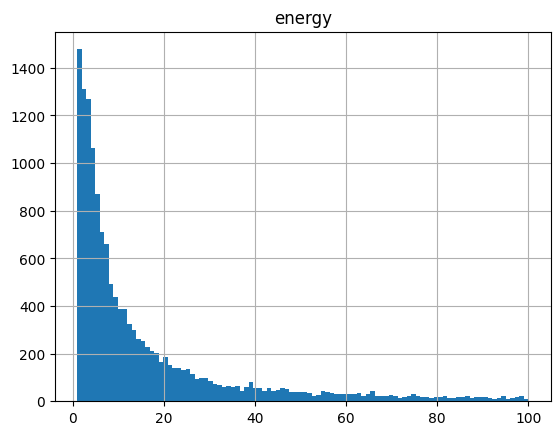

In [5]:
neutrinos = df[df["label"] == 1]
hist = neutrinos.hist(column='energy', bins=100)

## look at phase space

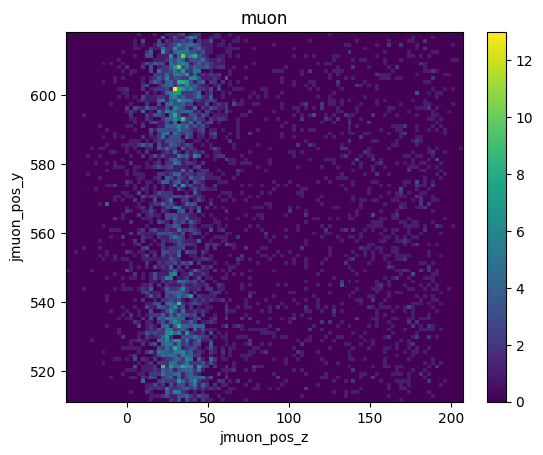

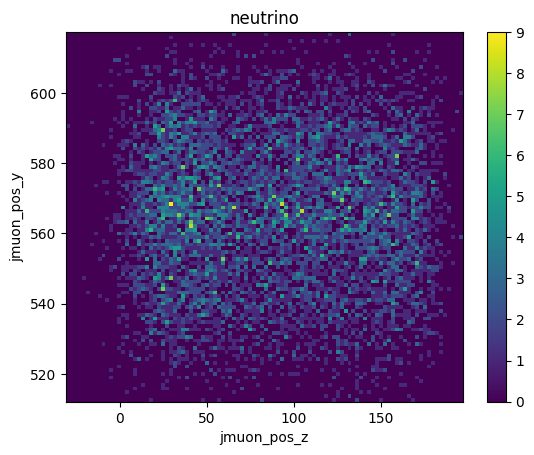

In [46]:
column_1 = "jmuon_pos_z"
column_2 = "jmuon_pos_y"

for label in [0,1]:
    if label == 0:
        mask = y_full["label"] == label
        label_name = "muon"
    else:
        mask = y_full["label"] == label
        label_name = "neutrino"
    
    hist = plt.hist2d(X_full[column_1][mask], X_full[column_2][mask], bins=100, cmap='viridis')
    plt.colorbar(hist[3])
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title(label_name)
    plt.show()



## training RDF 5 fold cross-validation

In [48]:
random_state = 42
study_name = "RDF_optuna_study_RDF"  
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name = study_name, direction="maximize", storage= storage_name, load_if_exists= True)
best_params = study.best_params
print(best_params)
max_samples = best_params["max_samples"]
max_features = best_params["max_features"]
n_estimators = best_params["n_estimators"]
class_weight = best_params["class_weight"]
criterion = best_params["criterion"]
min_samples_split = best_params["min_samples_split"]
# n_features = trial.suggest_int("n_features", 1, len(X_full.columns))

kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
exp_data = pd.DataFrame()

# rev_ordered_features = ['jmuon_JSTART_NPE_MIP', 'jmuon_JGANDALF_BETA0_RAD', 'jmuon_AASHOWERFIT_ENERGY', 'jmuon_JGANDALF_BETA1_RAD', 'jmuon_AASHOWERFIT_NUMBER_OF_HITS', 'jmuon_JGANDALF_LAMBDA', 'jmuon_JENERGY_NUMBER_OF_HITS', 'jmuon_t', 'jmuon_dir_x', 'jmuon_dir_y', 'jmuon_JENERGY_MAXIMAL_ENERGY', 'jmuon_JGANDALF_NUMBER_OF_ITERATIONS', 'jmuon_JENERGY_NDF', 'jmuon_JENERGY_NOISE_LIKELIHOOD', 'jmuon_JSHOWERFIT_ENERGY', 'jmuon_JENERGY_ENERGY', 'jmuon_JENERGY_MUON_RANGE_METRES', 'jmuon_E', 'jmuon_JGANDALF_NUMBER_OF_HITS', 'jmuon_JENERGY_CHI2', 'jmuon_JGANDALF_CHI2', 'jmuon_dir_z', 'jmuon_likelihood', 'jmuon_pos_z', 'jmuon_pos_y', 'jmuon_JENERGY_MINIMAL_ENERGY', 'jmuon_JSTART_NPE_MIP_TOTAL', 'jmuon_pos_x', 'jmuon_JSTART_LENGTH_METRES']


# X_selected_features = X_full[rev_ordered_features[-n_features:]]
X_selected_features = X_full.copy()

for train_index, test_index in kfold.split(X_selected_features):

    X_train, X_test = X_selected_features.iloc[train_index].copy(), X_selected_features.iloc[test_index].copy()
    y_train_compl, y_test_compl = y_full.iloc[train_index].copy(), y_full.iloc[test_index].copy()

    y_train = y_train_compl['label']

    clf = RFC(n_estimators=n_estimators, criterion= criterion, random_state=random_state, class_weight=class_weight, verbose = 0, n_jobs=-1, min_samples_split=min_samples_split, max_samples = max_samples, max_features = max_features)       
    clf.fit(X_train, y_train)

    prediction_probabilities = clf.predict_proba(X_test)
    y_pred = np.argmax(prediction_probabilities, axis = 1)

    y_test_compl['muon_score'] = prediction_probabilities[:,0]
    y_test_compl['prediction'] = y_pred
    y_test_compl['jmuon_E'] = X_test['jmuon_E']

    exp_data = pd.concat([exp_data, y_test_compl])

[I 2024-06-19 17:02:27,178] Using an existing study with name 'RDF_optuna_study_RDF' instead of creating a new one.


{'max_samples': 0.9030655639265075, 'max_features': 0.4058987597022825, 'n_estimators': 444, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 2}


## determine neutrino efficiency

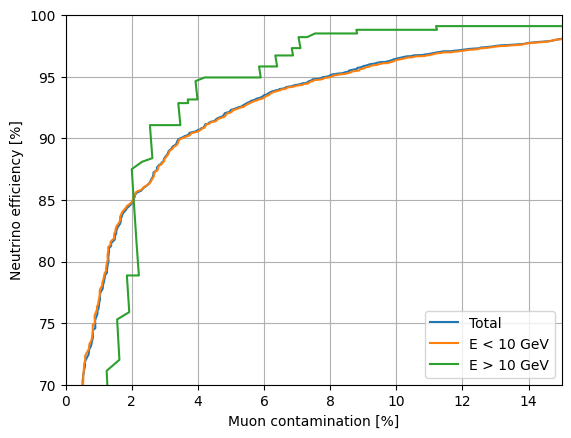

In [49]:
muons = exp_data[exp_data['label'] == 0]
neutrinos = exp_data[exp_data['label'] == 1]

muons_under_10GeV = muons[muons['jmuon_E'] < 10]
muons_over_10GeV = muons[muons['jmuon_E'] >= 10]
neutrinos_under_10GeV = neutrinos[neutrinos['jmuon_E'] < 10]
neutrinos_over_10GeV = neutrinos[neutrinos['jmuon_E'] >= 10]

muon_contamination_total = muon_contamination(muons, neutrinos)
neutrino_efficiency_total = neutrino_efficiency(neutrinos)

muon_contamination_under_10GeV = muon_contamination(muons_under_10GeV, neutrinos_under_10GeV)
muon_contamination_over_10GeV = muon_contamination(muons_over_10GeV, neutrinos_over_10GeV)

neutrino_efficiency_under_10GeV = neutrino_efficiency(neutrinos_under_10GeV)
neutrino_efficiency_over_10GeV = neutrino_efficiency(neutrinos_over_10GeV)

plt.plot(muon_contamination_total, neutrino_efficiency_total, label = "Total")
plt.plot(muon_contamination_under_10GeV, neutrino_efficiency_under_10GeV, label = "E < 10 GeV")
plt.plot(muon_contamination_over_10GeV, neutrino_efficiency_over_10GeV, label = "E > 10 GeV")
plt.xlabel("Muon contamination [%]")
plt.ylabel("Neutrino efficiency [%]")
plt.grid()
plt.xlim(0,15)
plt.ylim(70,100)
plt.legend()

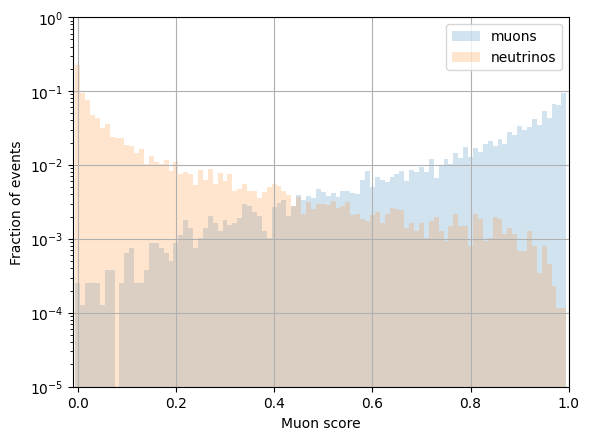

In [16]:
hist_muon_scores_muons, score_bins = np.histogram(muons['muon_score'], bins = 100, range = (0,1))
hist_muon_scores_neutrs = np.histogram(neutrinos['muon_score'], bins = 100, range = (0,1))[0]

frac_muon_score_muons = hist_muon_scores_muons/np.sum(hist_muon_scores_muons)
frac_muon_score_neutrs = hist_muon_scores_neutrs/np.sum(hist_muon_scores_neutrs)
min_y = min(np.min(frac_muon_score_muons), np.min(frac_muon_score_neutrs))

plt.figure()
plt.yscale('log')
plt.bar(score_bins[:-1], frac_muon_score_muons, width = 1/100, alpha = 0.2, label = "muons")
plt.bar(score_bins[:-1], frac_muon_score_neutrs, width = 1/100, alpha = 0.2, label = "neutrinos")
plt.ylabel("Fraction of events")
plt.xlabel("Muon score")
plt.ylim(10**-5, 1)
plt.xlim(-0.01,1)
plt.grid()
plt.legend()
plt.show()



## new figure of merit

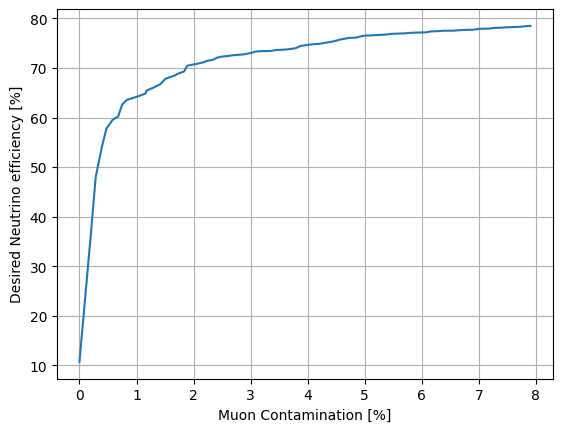

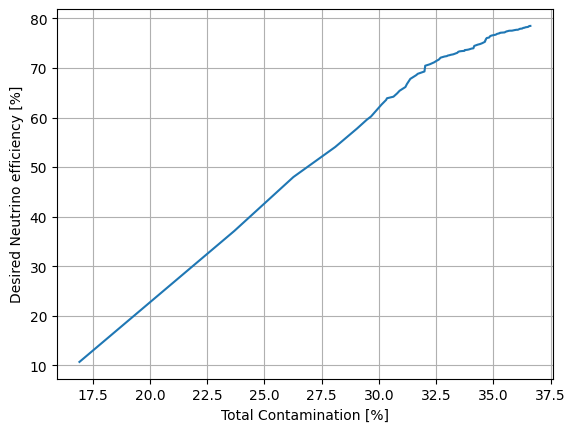

In [50]:
"""
Needs to quantify the amount of usefull/desired neutrinos that are available after the entire process.
Will need to be weighted according to the flux of neutrinos at the different energies/ for different neutrinos.
Roughest estimate would be to take the neutrino efficiency but take out the neutrinos that have a true energy higher than 20 GeV.
Could also filter out neutrinos that are not truly upgoing.
Should try these things out first.

But now how to visualize this?
Simplest is just a number.

Should i constrain on true energy and dir or reconstructed?

"""
muon_contamination_restriction = 1

n_desired_neutrinos_total = df_atm_neutr[(df_atm_neutr['dir_z']>0)&(df_atm_neutr["energy"]<=20)].shape[0]
muons = exp_data[exp_data['label'] == 0]
neutrinos = exp_data[exp_data['label'] == 1]

desired_neutrinos_efficiency = []
muon_contamination_percentages = []
contamination_percentages = []

for quantile in np.linspace(0,0.1,100):
    muon_score_threshold = np.quantile(muons['muon_score'], quantile)
    n_remaining_muons = muons[muons['muon_score'] < muon_score_threshold].shape[0]
    mask_desired_neutrinos = (neutrinos['muon_score'] < muon_score_threshold) & (neutrinos['energy'] <= 20) & (neutrinos['dir_z'] > 0)
    n_remaining_neutrinos = np.sum(neutrinos['muon_score'] < muon_score_threshold)
    n_remaining_desired_neutrinos = np.sum(mask_desired_neutrinos)
    desired_neutrinos_efficiency.append(n_remaining_desired_neutrinos/n_desired_neutrinos_total*100)
    n_muons_remaining = muons[muons['muon_score'] < muon_score_threshold].shape[0]
    muon_contamination_percentages.append(n_muons_remaining/(n_muons_remaining + n_remaining_desired_neutrinos)*100)
    contamination_percentages.append((n_muons_remaining+n_remaining_neutrinos - n_remaining_desired_neutrinos)/(n_muons_remaining + n_remaining_neutrinos)*100)
    # muon_contamination_remaining = n_muons_remaining/(n_muons_remaining + n_remaining_desired_neutrinos)
    # print("muon contamination remaining: ", muon_contatimination_remaining)

plt.plot(muon_contamination_percentages, desired_neutrinos_efficiency)
plt.xlabel("Muon Contamination [%]")
plt.ylabel("Desired Neutrino efficiency [%]")
plt.grid()
plt.show()

plt.plot(contamination_percentages, desired_neutrinos_efficiency)
plt.xlabel("Total Contamination [%]")
plt.ylabel("Desired Neutrino efficiency [%]")
plt.grid()
plt.show()




## test scores and distributions wrong/right

Mean Test Score:  0.9132958323831998
Std Test Score:  0.0037851958240728662
The prediction difficulty for type  muon  is 0.022973550540427913 +- 0.002200989894401434
The prediction difficulty for type  neutrino_anti-elec-CC  is 0.12425970478282958 +- 0.01653109774836573
The prediction difficulty for type  neutrino_anti-muon-NC  is 0.17604455671308897 +- 0.027708240483613956
The prediction difficulty for type  neutrino_muon-CC  is 0.16272223455339357 +- 0.01445261872464011
The prediction difficulty for type  neutrino_muon-NC  is 0.18013328819668212 +- 0.0260179287797929
The prediction difficulty for type  neutrino_tau-CC  is 0.1522236415775128 +- 0.029549586837580414
The prediction difficulty for type  neutrino_anti-tau-CC  is 0.11576487552059937 +- 0.03312136134936172
The prediction difficulty for type  neutrino_anti-muon-CC  is 0.1575994740948649 +- 0.02873706792211759
The prediction difficulty for type  neutrino_elec-CC  is 0.13635559756364712 +- 0.022116461908415833


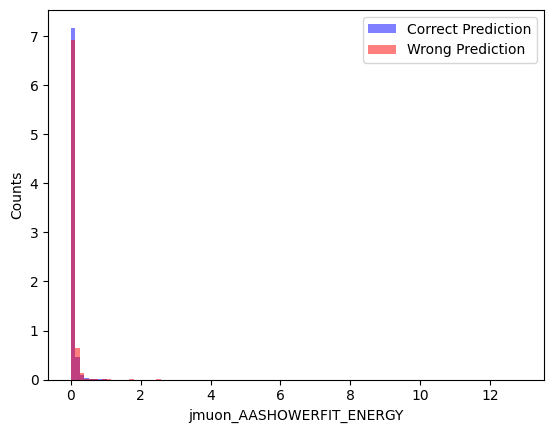

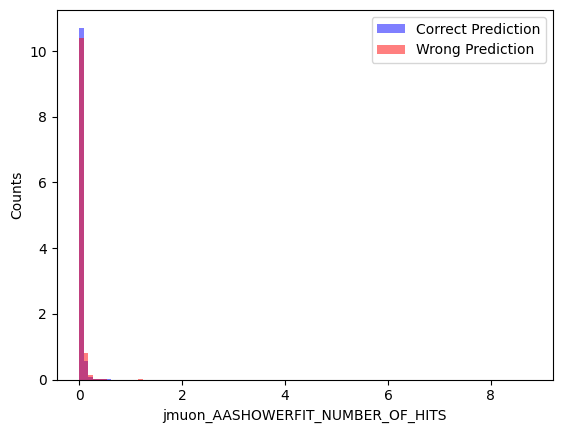

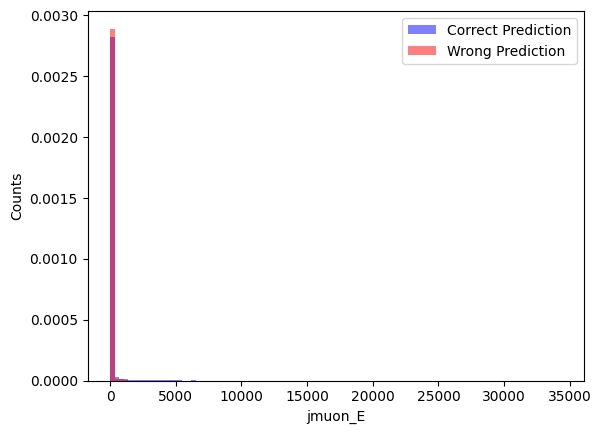

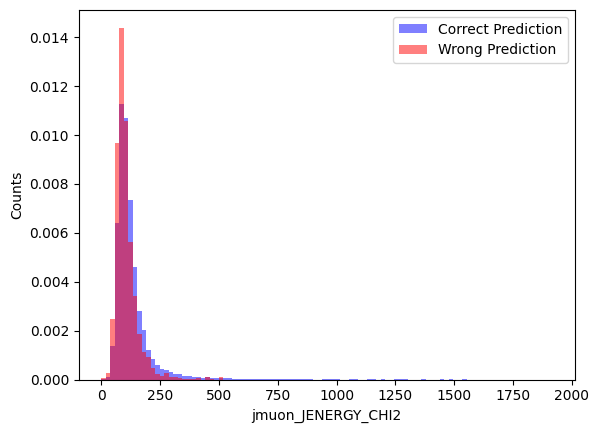

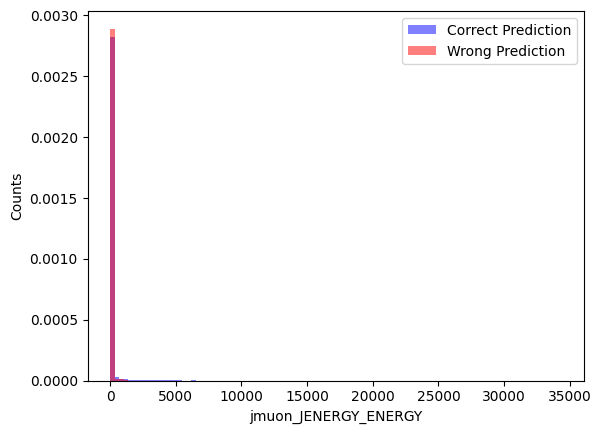

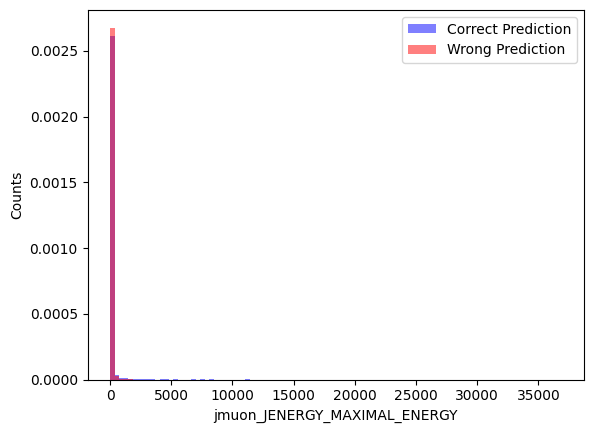

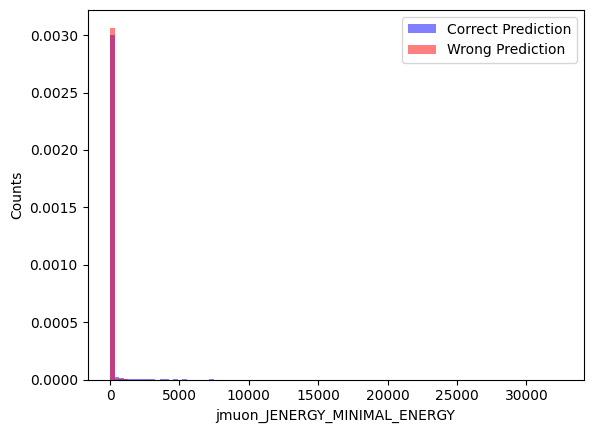

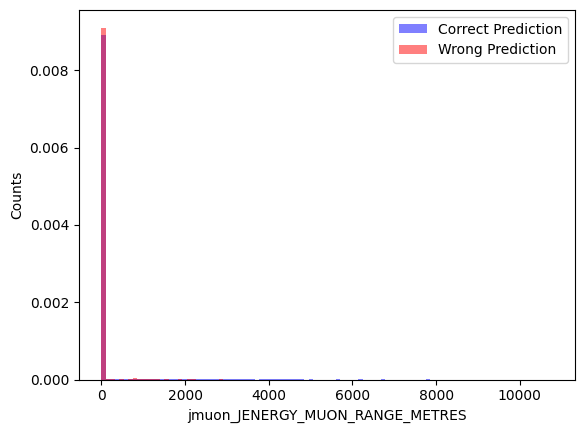

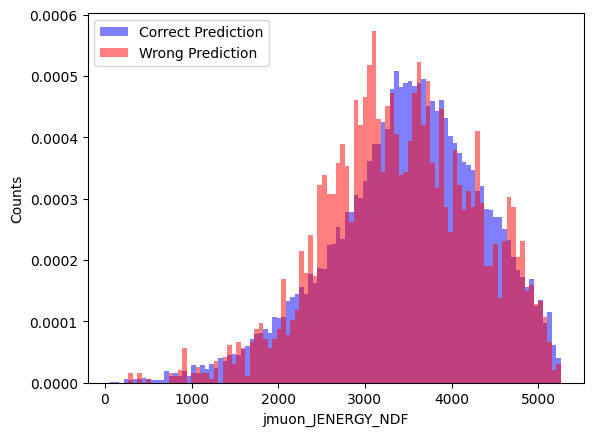

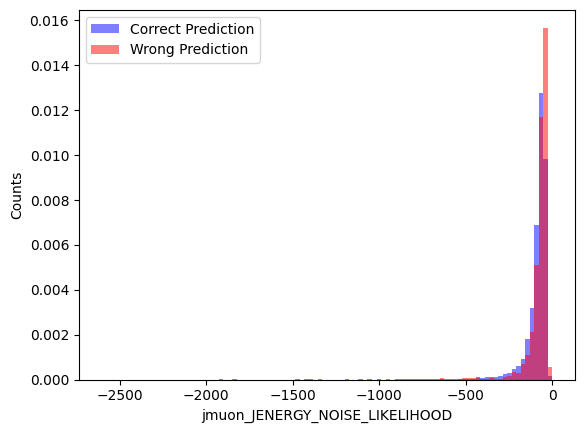

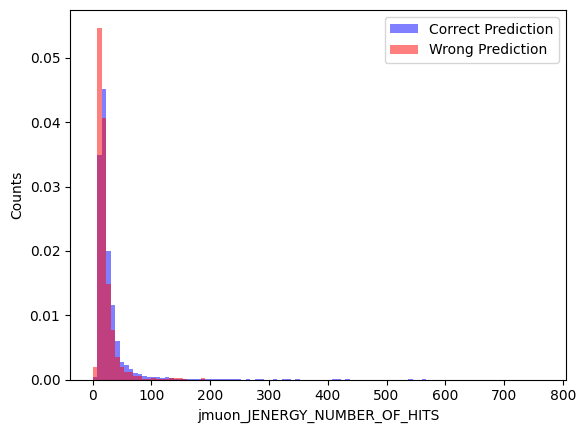

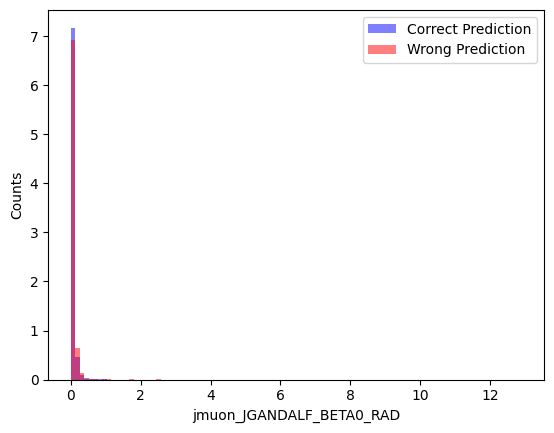

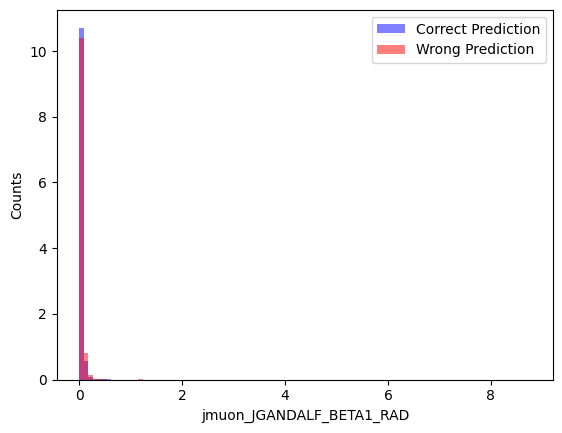

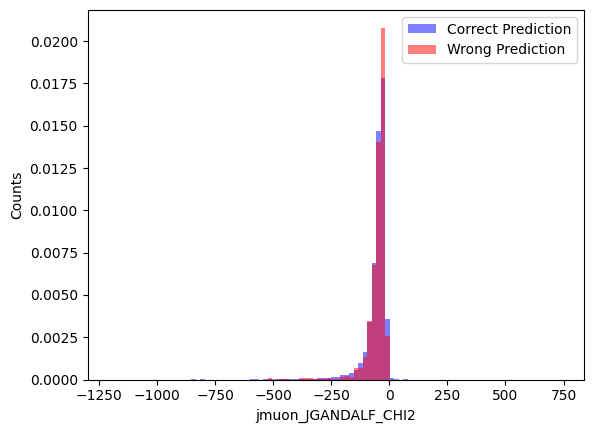

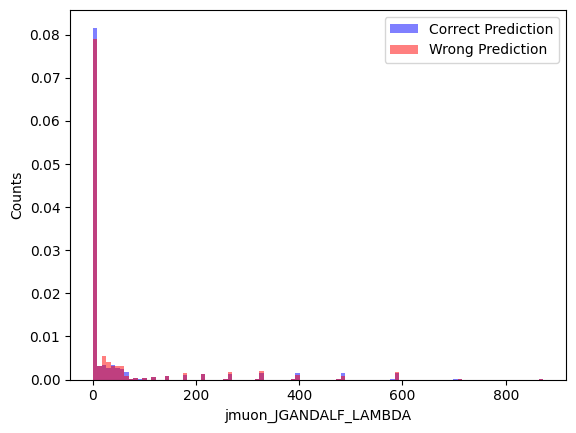

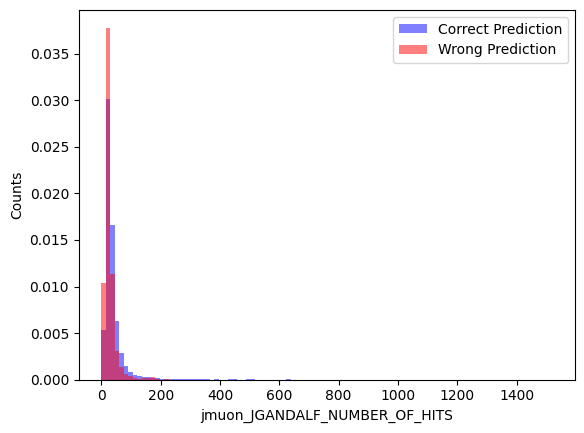

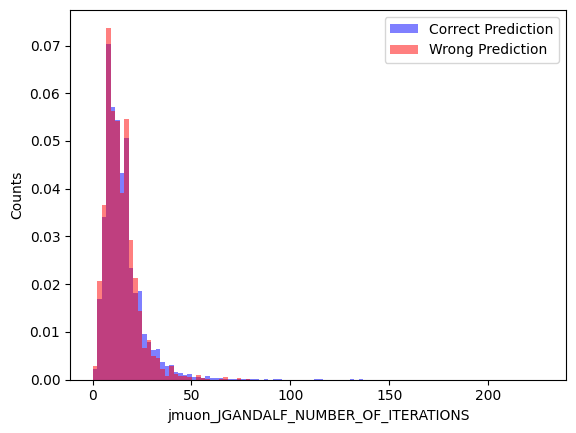

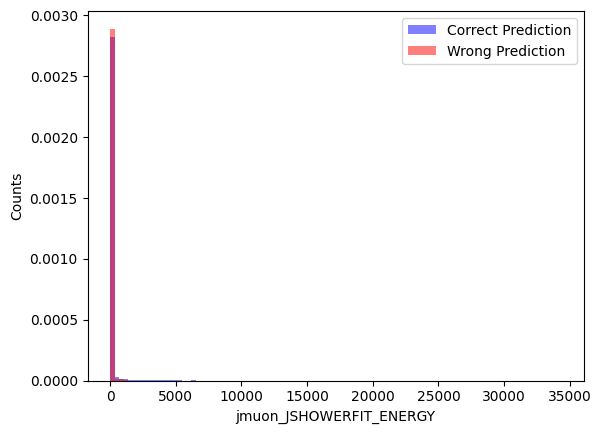

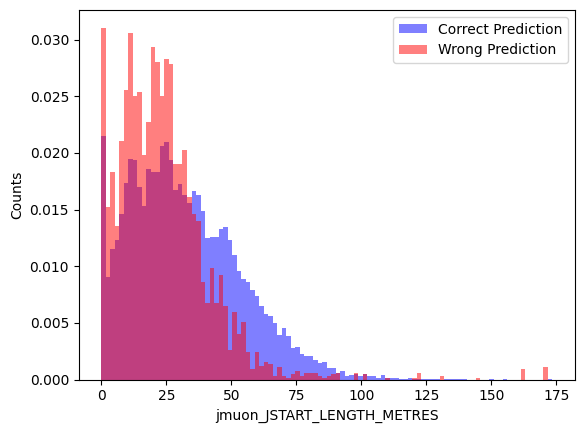

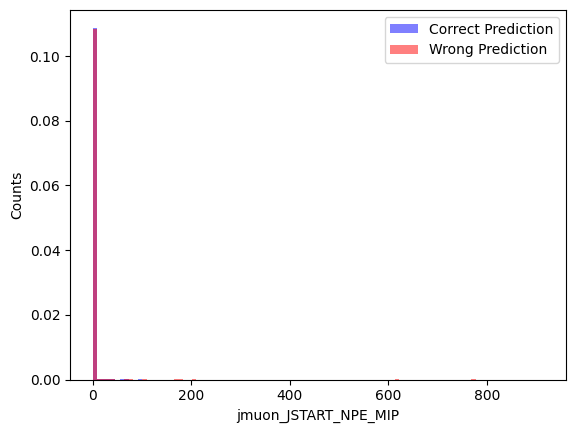

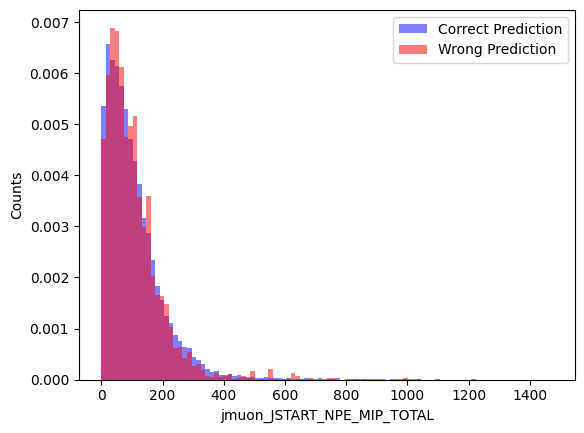

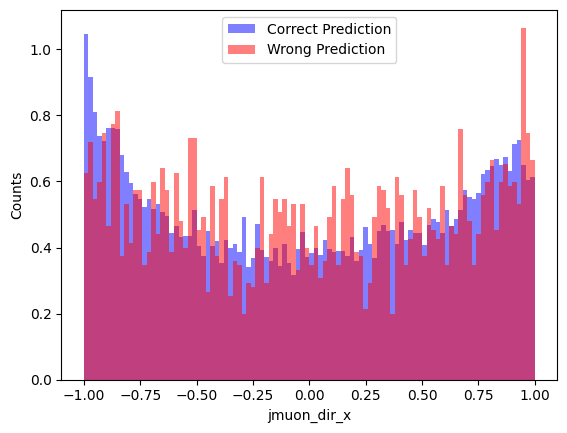

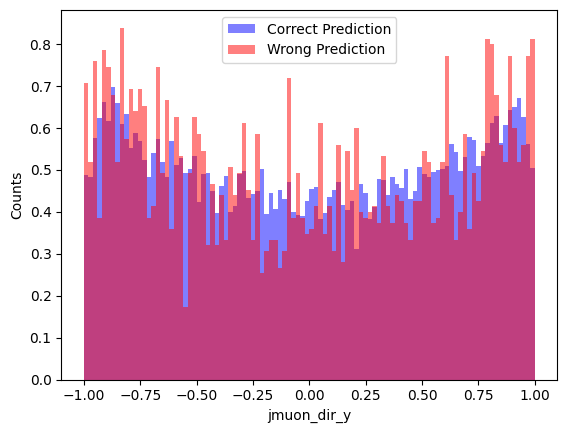

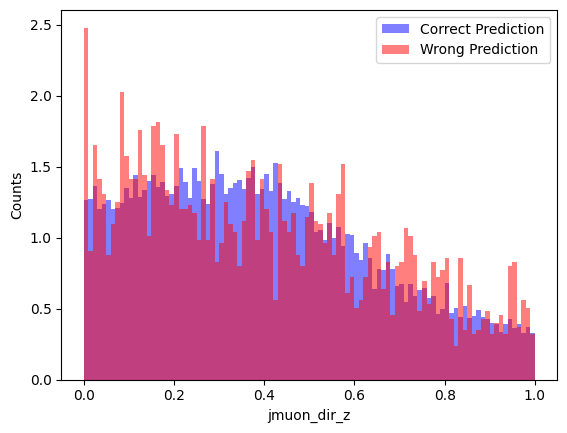

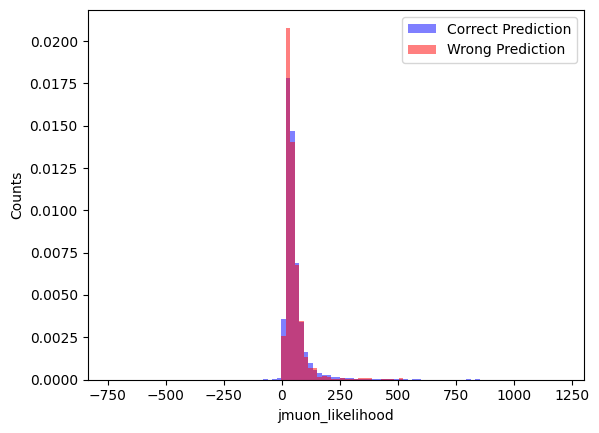

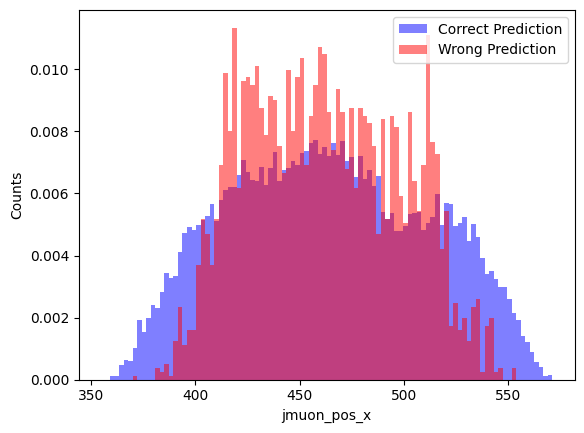

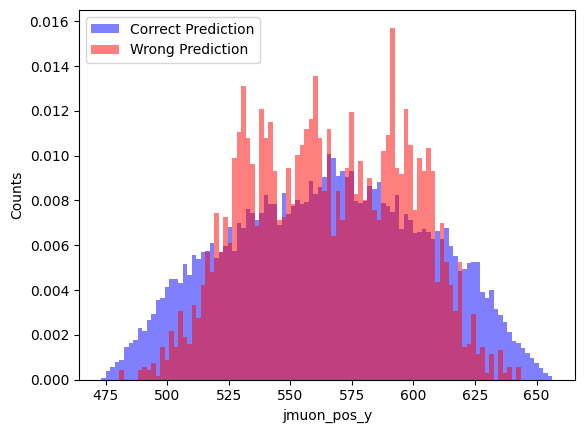

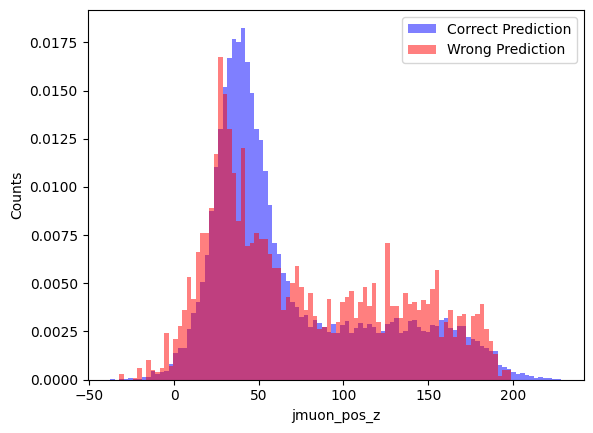

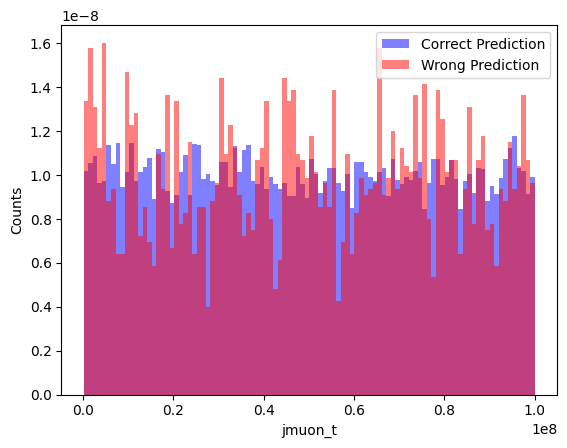

In [51]:
# test_scores, df_prediction_difficulties, hists_true, hists_false, columns, bins = experiment(paths_atm_muon, paths_atm_neutr, neutr_types, 50)
print("Mean Test Score: ", np.mean(test_scores))
print("Std Test Score: ", np.std(test_scores))

avg_prediction_difficulties = df_prediction_difficulties.mean()
std_prediction_difficulties = df_prediction_difficulties.std()
# print("The average prediction difficulty (fraction of wrong predictions) per type is:")
# print(avg_prediction_difficulties)
for column in df_prediction_difficulties.columns:
    print("The prediction difficulty for type ", column, " is", avg_prediction_difficulties[column], "+-", std_prediction_difficulties[column])

for i, column in enumerate(X.columns):
    plt.figure()
    plt.hist(bins[i][:-1], bins=bins[i], weights = hists_true[i], alpha=0.5, density= True, label='Correct Prediction', color='blue')
    plt.hist(bins[i][:-1], bins=bins[i], weights= hists_false[i], alpha=0.5, density= True, label='Wrong Prediction', color='red')
    plt.xlabel(column)
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

## 3D plots of the data

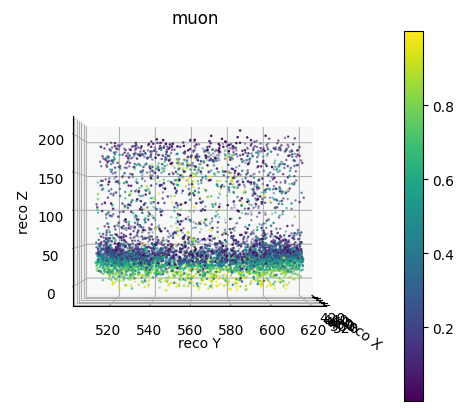

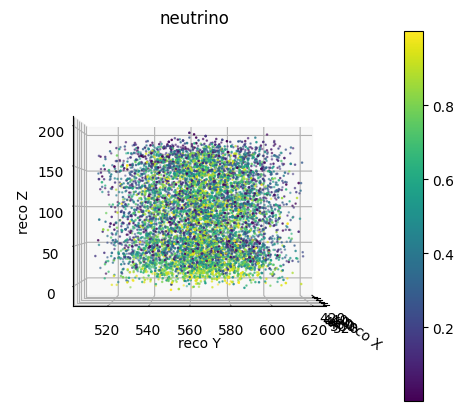

In [40]:
for label in [0,1]:
    if label == 0:
        name = "muon"
    else:
        name = "neutrino"
    
    X_particle = X_full[y_full['label'] == label]

    X = X_particle["jmuon_pos_x"]
    Y = X_particle["jmuon_pos_y"]
    Z = X_particle["jmuon_pos_z"]
    dir_Z = X_particle["jmuon_dir_z"]

    # fig, ax = plt.subplots()
    ax = plt.axes(projection='3d')
    ax.view_init(0, 0)
    p = ax.scatter3D(X, Y, Z, s = 0.7, c=dir_Z, cmap='viridis')
    ax.set_xlabel('reco X')
    ax.set_ylabel('reco Y')
    ax.set_zlabel('reco Z')
    ax.set_title(name)
    plt.colorbar(p)
    plt.show()


# orca 115 data

In [7]:
neutr_paths = ["data/mc_Orca115/table_y_reco/atm_neutrino_anti-muon-CC.h5", "data/mc_Orca115/table_y_reco/atm_neutrino_anti-tau-CC.h5", "data/mc_Orca115/table_y_reco/atm_neutrino_anti-elec-CC.h5", "data/mc_Orca115/table_y_reco/atm_neutrino_anti-muon-NC.h5", "data/mc_Orca115/table_y_reco/atm_neutrino_muon-CC.h5", "data/mc_Orca115/table_y_reco/atm_neutrino_tau-CC.h5", "data/mc_Orca115/table_y_reco/atm_neutrino_elec-CC.h5","data/mc_Orca115/table_y_reco/atm_neutrino_muon-NC.h5"]
muon_path = "data/mc_Orca115/table_y_reco/atm_muon.h5"
neutr_types = ["atm_neutrino_anti-muon-CC", "atm_neutrino_anti-tau-CC", "atm_neutrino_anti-elec-CC", "atm_neutrino_anti-muon-NC", "atm_neutrino_muon-CC", "atm_neutrino_tau-CC", "atm_neutrino_elec-CC", "atm_neutrino_muon-NC"]

# X_train, X_test, y_train, y_test, specific_types_train, specific_types_test = data_preprocessing(paths_atm_muon=paths_atm_muon, paths_atm_neutr=paths_atm_neutr, types_neutr = types, random_state=random_state)

In [9]:
df_muon, df_neutr = load_and_sample_RFD_data(muon_path, neutr_paths, neutr_types, True)
# Combine the dataframes
df = pd.concat([df_muon, df_neutr], join= 'inner', ignore_index=True)
print(df.value_counts('label'))

# Simulation data
reco_columns = [column for column in df.columns if column[:5] == "jmuon"]
y = df.drop(columns=reco_columns)
X = df[reco_columns]
# X = X.drop(columns=["jmuon_group_id"])
y = df.drop(columns=reco_columns)

# print(X.info)
# print(y.info)

# print(X['jmuon_group_id'].value_counts())


Number of atm_muon events:  2684
Number of  atm_neutrino_anti-muon-CC  events:  233
Number of  atm_neutrino_anti-tau-CC  events:  433
Number of  atm_neutrino_anti-elec-CC  events:  101
Number of  atm_neutrino_anti-muon-NC  events:  78
Number of  atm_neutrino_muon-CC  events:  590
Number of  atm_neutrino_tau-CC  events:  486
Number of  atm_neutrino_elec-CC  events:  253
Number of  atm_neutrino_muon-NC  events:  510
label
0    2684
1    2684
Name: count, dtype: int64


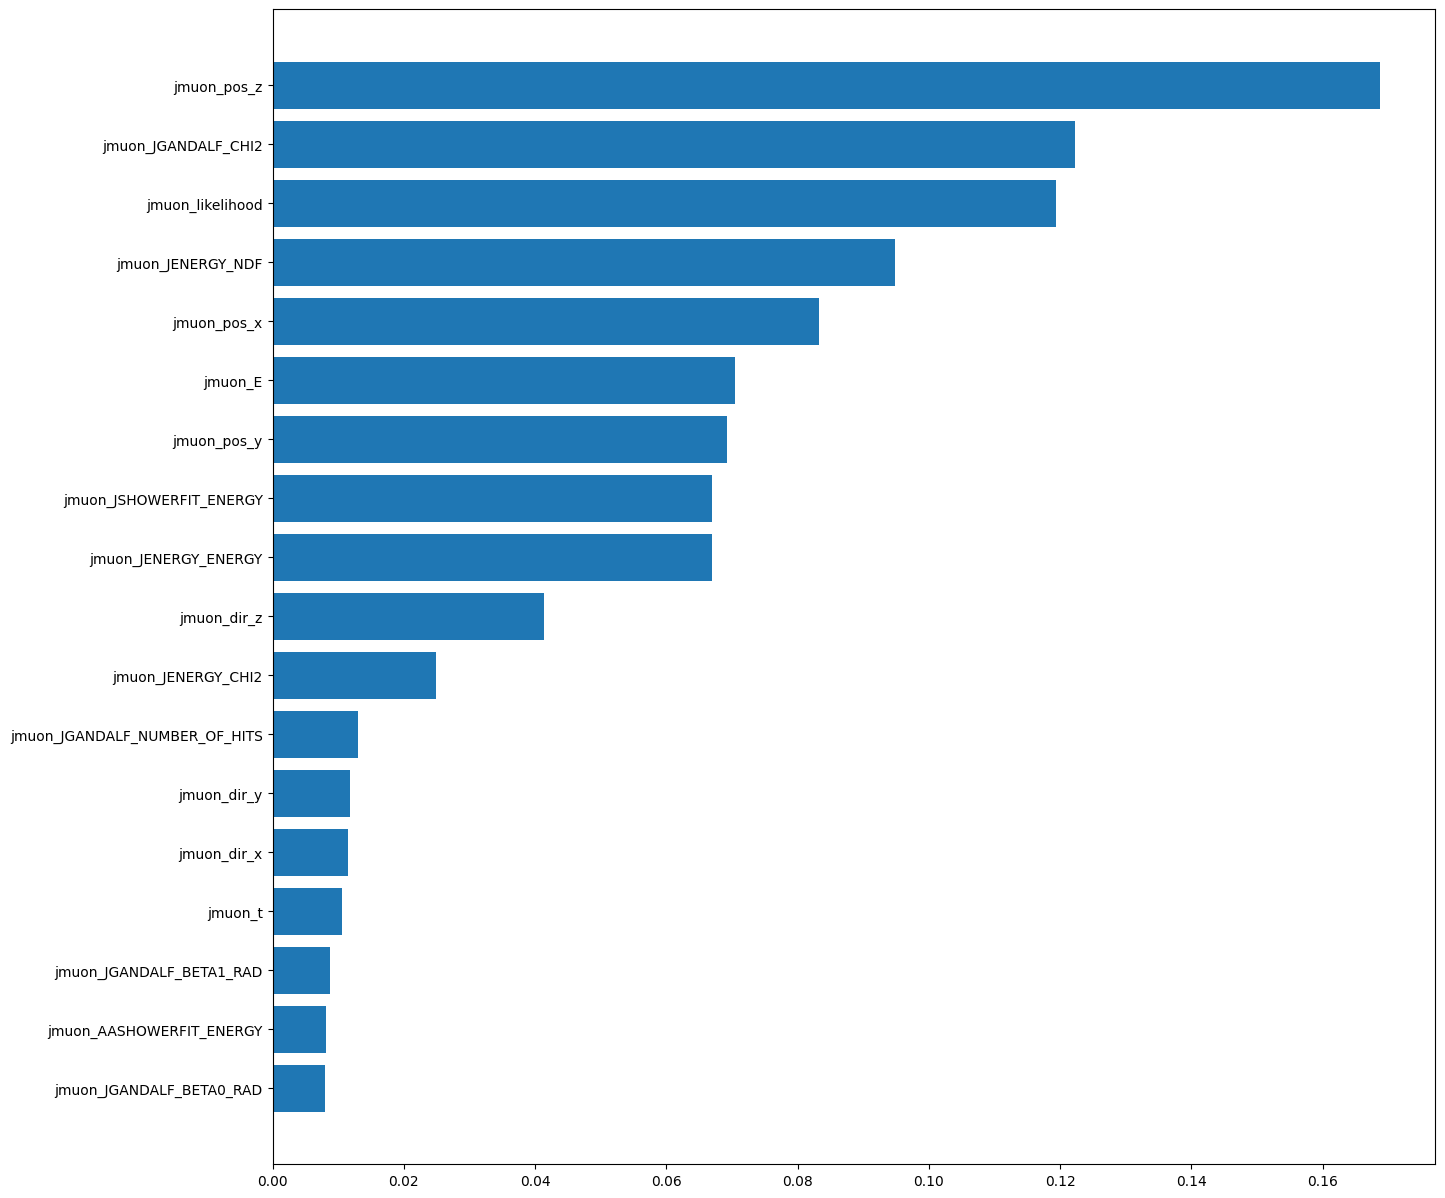

In [10]:
n_its = 20
random_states = np.arange(n_its)
test_scores = []
df_prediction_difficulties = pd.DataFrame()
n_bins = 100
n_estimators = 101
class_weight = {0:1, 1:1}


bins = determine_bins(X, n_bins)
hists_true = np.zeros((len(X.columns), n_bins), dtype = int)
hists_false = np.zeros((len(X.columns), n_bins), dtype = int)

feature_importances = np.zeros(len(X.columns))


for random_state in random_states:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y , shuffle = True, test_size=0.2, random_state=random_state)
    labels_train = y_train['label']
    labels_test = y_test['label']
    

    specific_types_test = y_test['type']
    # specific_types_train = X_train_full['type']
    clf = RFC(n_estimators=n_estimators, random_state=random_state, class_weight=class_weight, oob_score=True, verbose = 0, n_jobs=-1, max_samples = 0.4, max_features = 0.6)
    clf.fit(X_train, labels_train)
    

    test_scores.append(clf.score(X_test, labels_test))
    df_prediction_difficulties = pd.concat([prediction_difficulties_types(specific_types_test, X_test, labels_test, clf), df_prediction_difficulties])

    hists_true, hists_false = histogram_dependency_variables(X_test, labels_test, clf, hists_true, hists_false, bins)

    feature_importances += clf.feature_importances_

plt.figure(figsize=(15,15))
f_i = list(zip(X_train.columns , feature_importances/n_its))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()



Mean Test Score:  0.9443668528864059
Std Test Score:  0.00859376859496032
The prediction difficulty for type  atm_neutrino_muon-NC  is 0.0610315878344026 +- 0.021039865295207016
The prediction difficulty for type  atm_neutrino_tau-CC  is 0.08958006194485776 +- 0.02781959310193476
The prediction difficulty for type  muon  is 0.04420151050763189 +- 0.009810175197574645
The prediction difficulty for type  atm_neutrino_anti-tau-CC  is 0.08400032214063148 +- 0.04040359284478837
The prediction difficulty for type  atm_neutrino_elec-CC  is 0.06201775939979183 +- 0.03412571458285851
The prediction difficulty for type  atm_neutrino_muon-CC  is 0.061079488783242784 +- 0.021440329339111032
The prediction difficulty for type  atm_neutrino_anti-muon-CC  is 0.03625620717397078 +- 0.020980301111228703
The prediction difficulty for type  atm_neutrino_anti-muon-NC  is 0.09038004371789202 +- 0.06858516945889885
The prediction difficulty for type  atm_neutrino_anti-elec-CC  is 0.022352908135609372 +- 0.0

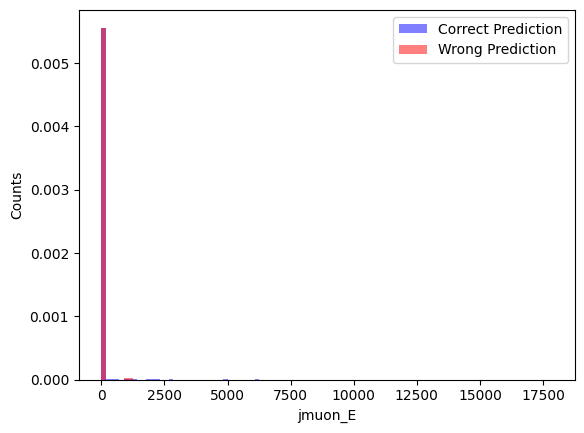

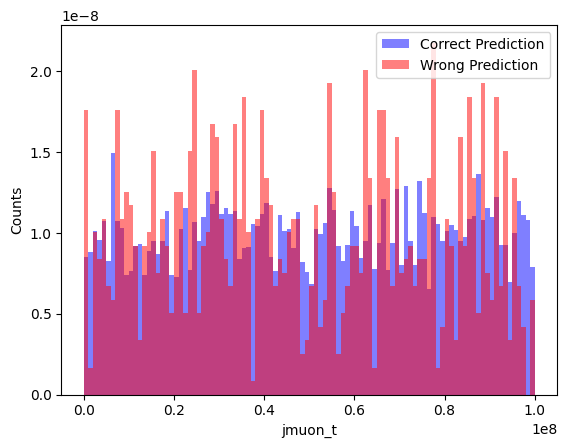

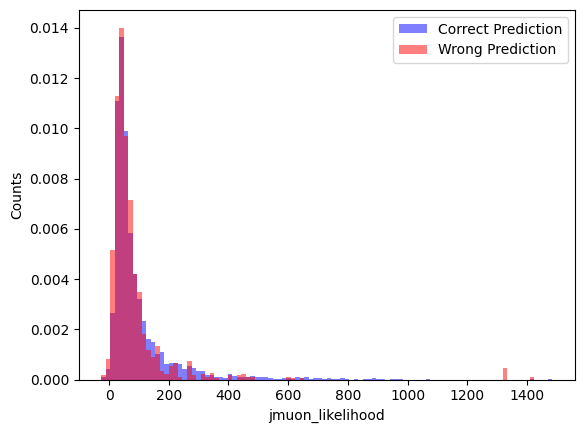

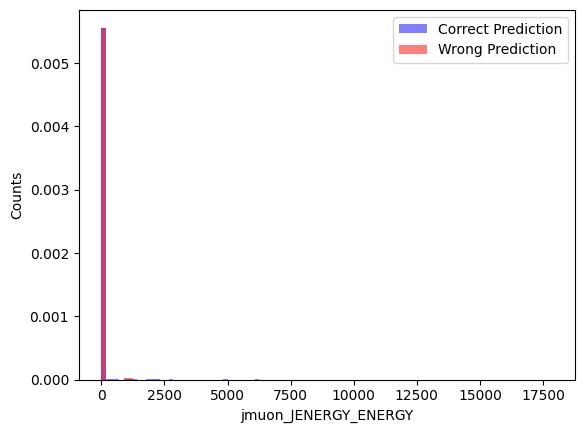

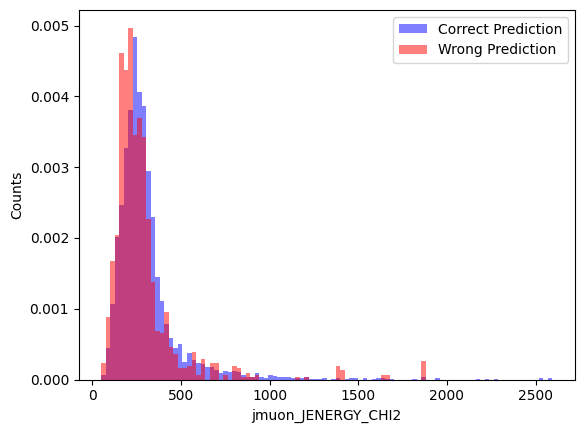

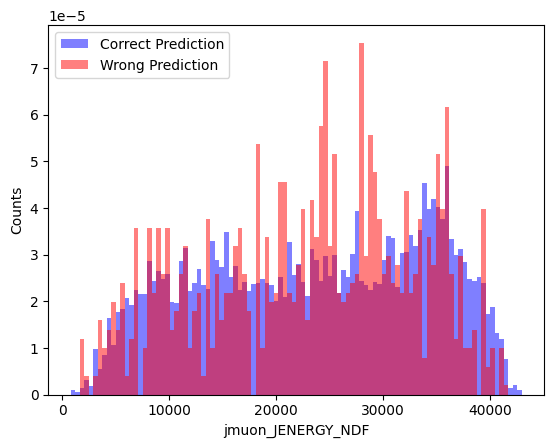

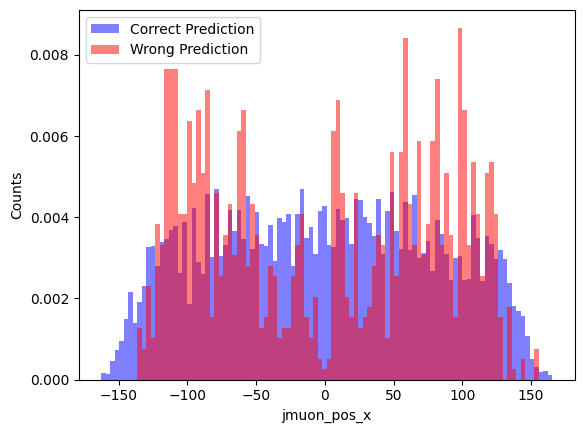

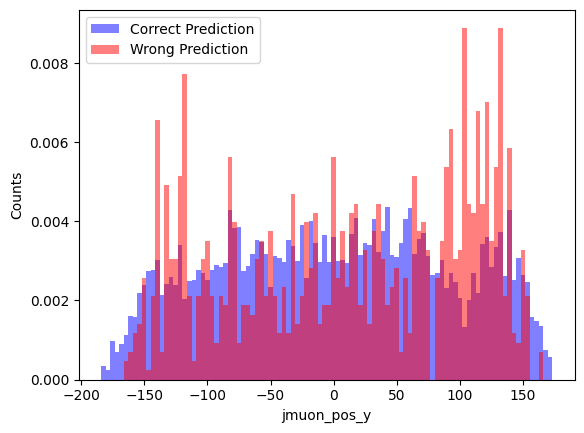

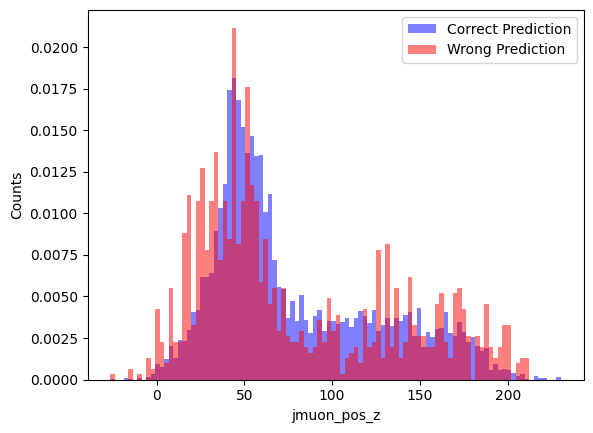

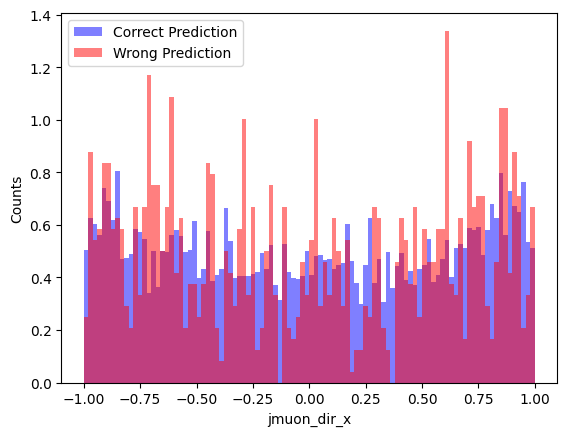

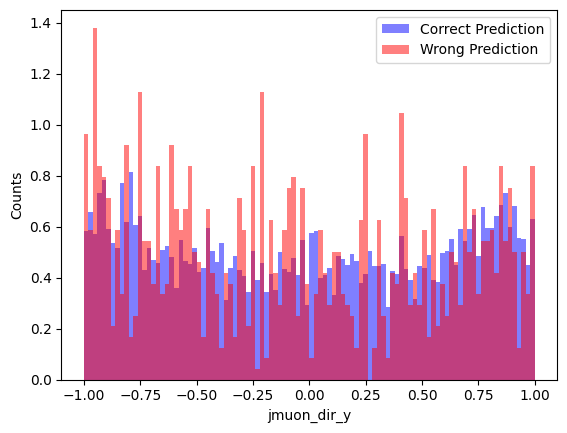

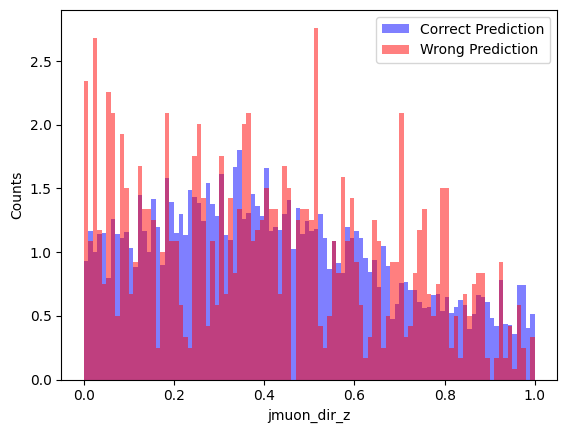

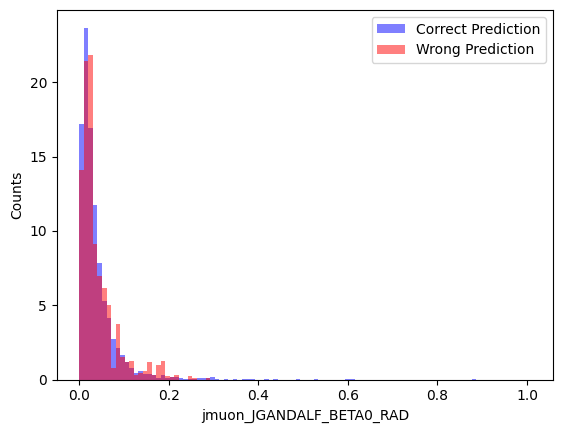

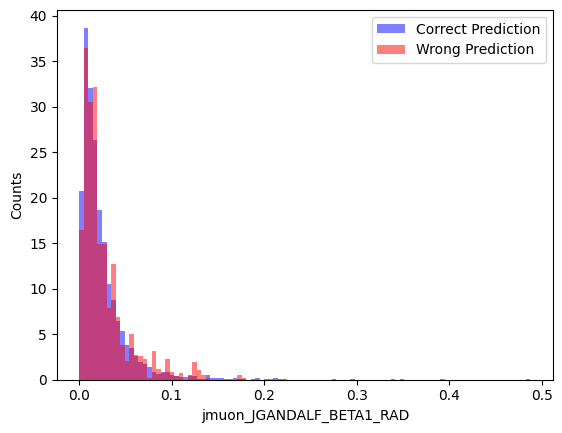

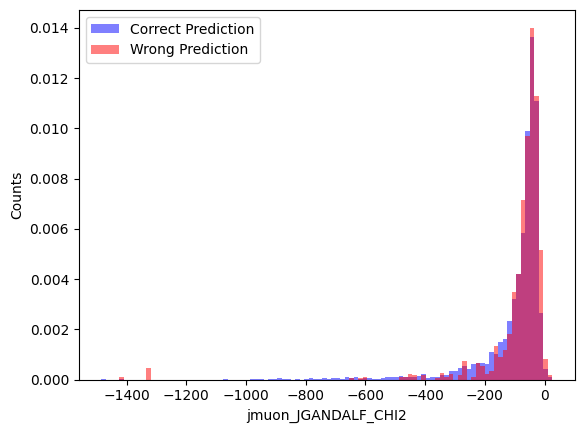

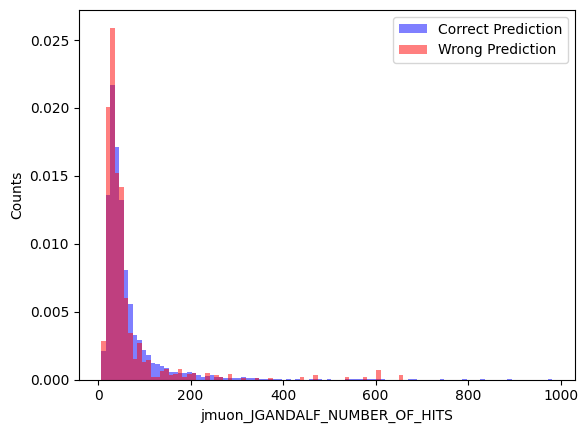

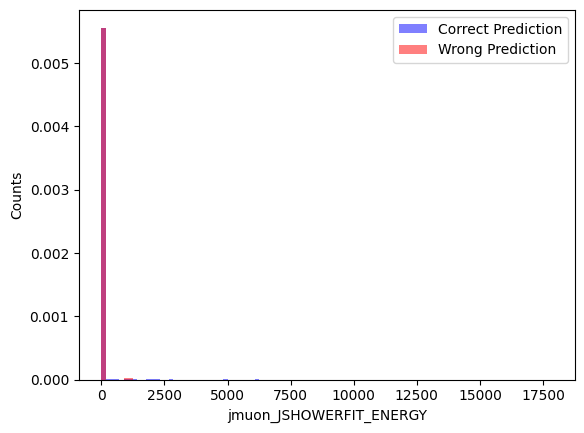

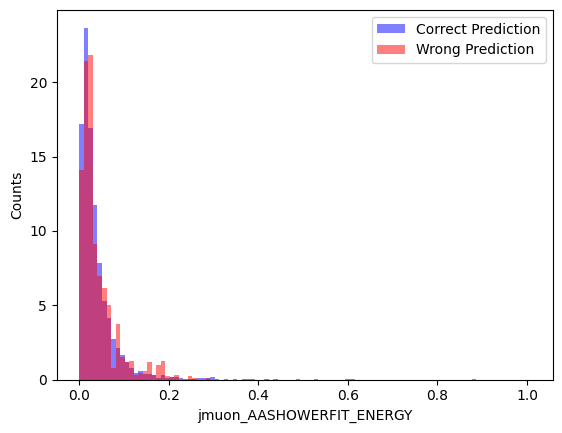

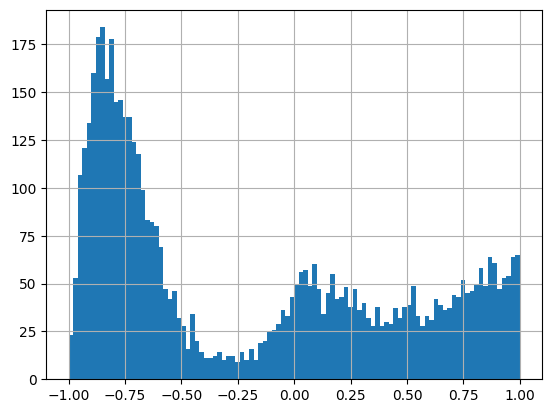

In [12]:
# test_scores, df_prediction_difficulties, hists_true, hists_false, columns, bins = experiment(paths_atm_muon, paths_atm_neutr, neutr_types, 50)
print("Mean Test Score: ", np.mean(test_scores))
print("Std Test Score: ", np.std(test_scores))

avg_prediction_difficulties = df_prediction_difficulties.mean()
std_prediction_difficulties = df_prediction_difficulties.std()
# print("The average prediction difficulty (fraction of wrong predictions) per type is:")
# print(avg_prediction_difficulties)
for column in df_prediction_difficulties.columns:
    print("The prediction difficulty for type ", column, " is", avg_prediction_difficulties[column], "+-", std_prediction_difficulties[column])

for i, column in enumerate(X.columns):
    plt.figure()
    plt.hist(bins[i][:-1], bins=bins[i], weights = hists_true[i], alpha=0.5, density= True, label='Correct Prediction', color='blue')
    plt.hist(bins[i][:-1], bins=bins[i], weights= hists_false[i], alpha=0.5, density= True, label='Wrong Prediction', color='red')
    plt.xlabel(column)
    plt.ylabel('Counts')
    plt.legend()
    plt.show()
    
true_z_dir = df['dir_z']
hist = true_z_dir.hist(bins=100)
